In [1]:
import tqdm
from iqoptionapi.stable_api import IQ_Option
import json 
import statistics
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections as cll
import scipy.stats

connector =IQ_Option("ww.bingonemo@gmail.com","JF*#3C5va&_NDqy")
connector.connect()

(True, None)

In [2]:
seconds_in_month = 2_592_000 
seconds_in_year = 31_536_000
max_dict = 1000
iqcomb = [("NZD", "SEK"),("NZD", "USD"),("CAD", "TRY"),("EUR", "CHF"),("USD", "THB"),("EUR", "TRY"),("GBP", "AUD"),("AUD", "USD"),("EUR", "MXN"),("USD", "CHF"),("NOK", "DKK"),("EUR", "NOK"),("SEK", "JPY"),("CAD", "NOK"),("NOK", "SEK"),("GBP", "HUF"),("GBP", "SGD"),("AUD", "NZD"),("GBP", "JPY"),("CHF", "SEK"),("AUD", "NOK"),("GBP", "NOK"),("AUD", "DKK"),("EUR", "AUD"),("AUD", "CHF"),("GBP", "CHF"),("AUD", "CAD"),("CHF", "DKK"),("AUD", "TRY"),("NZD", "CHF"),("USD", "SEK"),("GBP", "NZD"),("EUR", "DKK"),("NZD", "DKK"),("CAD", "SGD"),("EUR", "GBP"),("EUR", "CAD"),("USD", "CZK"),("AUD", "MXN"),("EUR", "NZD"),("GBP", "PLN"),("NZD", "NOK"),("AUD", "SGD"),("GBP", "SEK"),("NZD", "CAD"),("NZD", "MXN"),("NZD", "TRY"),("CHF", "SGD"),("USD", "MXN"),("EUR", "HUF"),("GBP", "CAD"),("USD", "TRY"),("USD", "JPY"),("EUR", "USD"),("AUD", "SEK"),("CHF", "NOK"),("USD", "PLN"),("USD", "HUF"),("CHF", "JPY"),("GBP", "ILS"),("NZD", "JPY"),("CHF", "TRY"),("CAD", "JPY"),("USD", "RUB"),("SGD", "JPY"),("GBP", "USD"),("CAD", "PLN"),("DKK", "SGD"),("NZD", "SGD"),("AUD", "JPY"),("NOK", "JPY"),("PLN", "SEK"),("USD", "SGD"),("GBP", "MXN"),("USD", "CAD"),("SEK", "DKK"),("DKK", "PLN"),("CAD", "MXN"),("GBP", "TRY"),("EUR", "SGD"),("NZD", "ZAR"),("EUR", "CZK"),("EUR", "JPY"),("CAD", "CHF"),("USD", "INR"),("USD", "BRL"),("USD", "NOK"),("USD", "DKK")]
candle_size = 3600 # 3600 is one hour
quantity = 5 * seconds_in_year / candle_size

In [68]:
end_from_time=time.time()
ANS=[]
for i in tqdm.tqdm(range(int(quantity/max_dict) + 1)):
    data=connector.get_candles("BTCUSD", candle_size, max_dict, end_from_time)
    ANS =data+ANS
    end_from_time=int(data[0]["from"])-1
print(ANS[0], len(ANS))
%store ANS

100%|██████████| 44/44 [00:27<00:00,  1.63it/s]

{'id': -7253, 'from': 1483146000, 'at': 1483149600999999999, 'to': 1483149600, 'open': 955.305, 'close': 950.135, 'min': 947.805, 'max': 955.305, 'volume': 0} 43523
Stored 'ANS' (list)


In [69]:
ANSmean = statistics.mean([x['close'] for x in ANS])
ANSstd =  statistics.stdev([x['close'] for x in ANS])
ANSmean

15205.412940997083

In [71]:
period = 8 * 3600

peakdiffset = []
timediffset = []
percset = []
idiffset = []

for i in ANS:
    if  ANS[-1]['from'] - i['from'] < period:
        continue
    period_candle_set = []
    for k in ANS:
        if k["from"] - i["from"] <= period and k["from"] - i["from"] > 0:
            period_candle_set.append(k)

    if len(period_candle_set) == 0:
        continue


    peakvalue = {'close': np.NINF}
    maxpeakvalue = {'max': np.NINF}

    for x in period_candle_set:
        if x['close'] > peakvalue['close']:
            peakvalue = x
        
        if x['max'] > maxpeakvalue['max']:
            maxpeakvalue = x

    peakdiff = peakvalue['close'] - i['close']
    maxpeakdiff = maxpeakvalue['close'] - i['max']
    timediff = peakvalue['from'] - i['from']
    maxtimediff = maxpeakvalue['from'] - i['from']

    perc = peakdiff/i['close']

    idiff = ANSmean - i['close']

    peakdiffset.append(peakdiff)
    timediffset.append(timediff)
    percset.append(perc)
    idiffset.append(idiff)

In [72]:
fset = [x for x in peakdiffset if x >= 0]
fpr = [x for x in percset if x >= 0]
ftm = [y for x, y in zip(peakdiffset, timediffset) if x>= 0 ]
fidf = [y for x, y in zip(peakdiffset, idiffset) if x>= 0 ] # mean deviation
print('Average increment: ',len(fset), statistics.mean(fset), statistics.stdev(fset))
print('Average percent: ', len(fpr), statistics.mean(fpr), statistics.stdev(fpr))
print('Average time:', len(ftm), statistics.mean(ftm), statistics.stdev(ftm))
print(len(fidf), format(statistics.mean(fidf), 'f'), statistics.stdev(fidf))

Average increment:  35833 236.26895314246644 428.6257059865798
Average percent:  35833 0.015093936392831955 0.017653842046543754
Average time: 35833 17458.287053833057 8941.753266913774
35833 142.494977 16693.60373204537


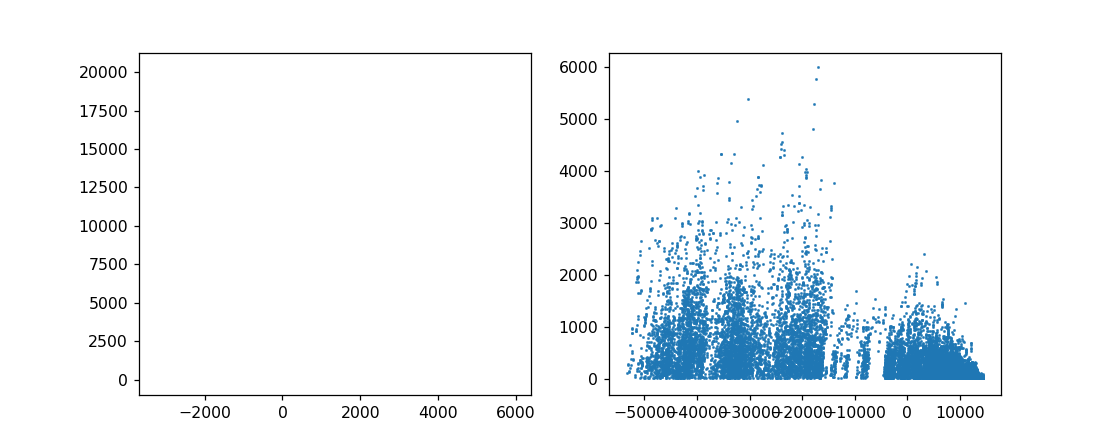

In [73]:
%matplotlib widget
cm = 1/2.54  # centimeters in inches

fig, ax = plt.subplots(1, 2, figsize=(25*cm, 10*cm), dpi=113)
div = 100
        
c = cll.Counter(pd.cut(peakdiffset, div))
ax[0].scatter([x.mid for x in c.keys()], c.values(), marker= 's' , s=0.29)
ax[1].scatter(fidf, fset, marker= ',' , s=0.40599)


In [128]:
### Constants from data
ANSmean
ANSstd
delta_price_mean = statistics.mean(fset)
delta_price_std = statistics.stdev(fset)

### Variables to choose
opening_price = ANSmean
leverage = 125
CurDelta = delta_price_mean 
disDeltaPrice = scipy.stats.norm(delta_price_mean,  delta_price_std)

### Calculations
pr = (disDeltaPrice.sf(CurDelta)/disDeltaPrice.sf(0)) - disDeltaPrice.cdf(0)
s_1 = len(fset)/len(peakdiffset)
closing_price = opening_price + CurDelta
m = ((closing_price/opening_price) - 1) * leverage
expected_value = m*(pr*s_1) - ( 1- pr*s_1)
print(expected_value)
print(opening_price)

0.003630142196548558
15205.412940997083


In [129]:
def Ross614A (CurDelta):
    ### Constants from data
    ANSmean
    ANSstd
    delta_price_mean = statistics.mean(fset)
    delta_price_std = statistics.stdev(fset)

    ### Variables to choose
    opening_price = ANSmean
    leverage = 125
    disDeltaPrice = scipy.stats.norm(delta_price_mean,  delta_price_std)

    ### Calculations
    pr = (disDeltaPrice.sf(CurDelta)/disDeltaPrice.sf(0)) - disDeltaPrice.cdf(0)
    s_1 = len(fset)/len(peakdiffset)
    closing_price = opening_price + CurDelta
    m = ((closing_price/opening_price) - 1) * leverage
    expected_value = m*(pr*s_1) - ( 1- pr*s_1)
    return expected_value

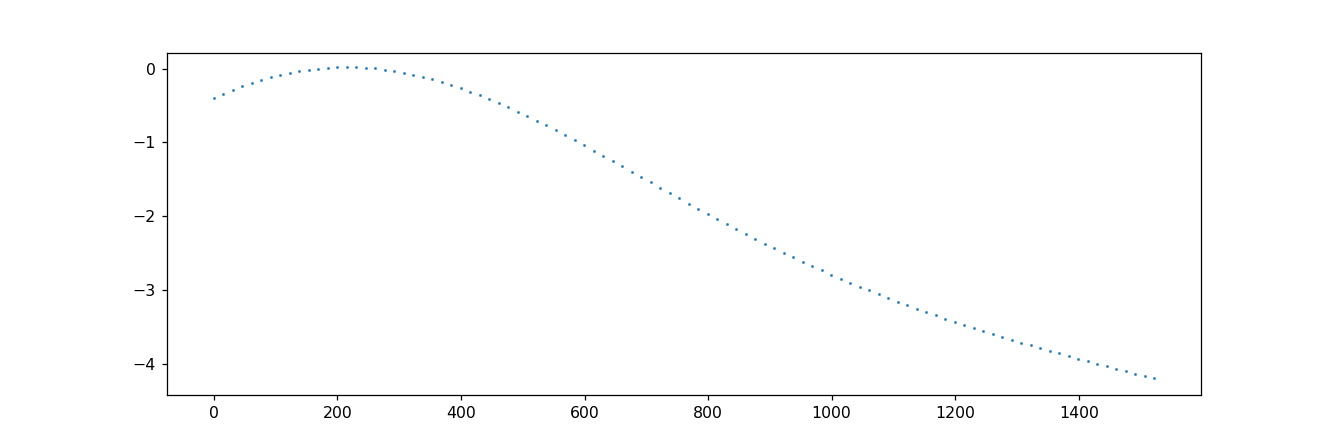

In [130]:
cm = 1/2.54  # centimeters in inches

fig = plt.figure(figsize=(30*cm, 10*cm), dpi=113)

x = np.linspace(0, statistics.mean(fset) + 3 * statistics.stdev(fset), 100)
ax = fig.add_subplot()
ax.scatter(x, [Ross614A(k) for k in x ], marker= ',' , s=0.40599)

In [152]:
def ProximaCentauri (CurDelta, opening_price, mu, leverage):

    ANSmean, delta_price_mean, delta_price_std, s_1 = mu

    disDeltaPrice = scipy.stats.norm(delta_price_mean,  delta_price_std)
    ### Calculations
    pr = (disDeltaPrice.sf(CurDelta)/disDeltaPrice.sf(0)) - disDeltaPrice.cdf(0)
    closing_price = opening_price + CurDelta
    m = ((closing_price/opening_price) - 1) * leverage
    expected_value = m*(pr*s_1) - ( 1- pr*s_1)
    return expected_value, m


In [153]:

def Kruger60B (current_price, leverage, mu):
    ### best expected value calculator
    ANSmean, delta_price_mean, delta_price_std, s_1 = mu

    firstsel = np.linspace(0, delta_price_mean + 3 * delta_price_std, 10)
    gsel = None
    for delta_price in firstsel:
        ev = ProximaCentauri(delta_price, current_price, mu, leverage)
        if gsel is None:
            gsel = ev + (delta_price,)
        elif ev[0] > gsel[0]:
            gsel = ev + (delta_price,)

    
    if gsel[1] == 0:
        secondsel = np.linspace(0, firstsel[1], 10)
    else:
        secondsel = np.linspace(gsel[1] - firstsel[1] , gsel[1] + firstsel[1], 11)

    for delta_price in secondsel:
        ev = ProximaCentauri(delta_price, current_price, mu, leverage)
        if gsel is None:
            gsel = ev + (delta_price,)
        elif ev[0] > gsel[0]:
            gsel = ev + (delta_price,)

    return gsel

In [169]:
Kruger60B(ANSmean, 128, (ANSmean, delta_price_mean, delta_price_std, s_1))

(0.0031290453448552524, 1.4357082136793622, 170.55106446700208)

In [78]:

def cbrute(m, p, Bs, n):
    shape = 1000
    zerosarg = np.zeros(shape, dtype=np.int)
    randomlib = np.random.choice([True, False],size=(91, shape), p=[p, (1 - p)])

    win = 0
    lose = 0
    for x in range(shape):
        B = Bs
        for y in range(91):
            if B/n <= 1:
                lose += 1
                zerosarg[x] = y
                break
            if B >= 2*Bs:
                win +=1
                zerosarg[x] = y
                break
            if randomlib[y][x]:
                B += (B/n) * m
            else:
                B -= (B/n)
        else:
            lose += 1
            zerosarg[x] = y 

    return win, lose, np.mean(zerosarg)


In [79]:
def ProcyonB (m, p, Bs):
    firstsel = np.linspace(1, 100, 11).astype(int)
    gsel = None
    for n in firstsel:
        wlm = cbrute(m, p, Bs, n)
        if gsel is None:
            gsel = wlm + (n,)
        elif wlm[0] > gsel[0]:
            gsel = wlm + (n,)
        elif wlm[0] == gsel[0] and gsel[2] > wlm[2]:
            gsel = wlm + (n,)
    
    if gsel[3] == 1:
        secondsel = np.linspace(2, 9, 8).astype(int)
    else:
        secondsel = np.linspace(gsel[3] - 5, gsel[3] + 5, 11).astype(int)

    for n in secondsel:
        wlm = cbrute(m, p, Bs, n)
        if gsel is None:
            gsel = wlm + (n,)
        elif wlm[0] > gsel[0]:
            gsel = wlm + (n,)
        elif wlm[0] == gsel[0] and gsel[2] > wlm[2]:
            gsel = wlm + (n,)

    return gsel

In [81]:
ProcyonB(m, pr*s_1, 10000* 1000)

(0, 1000, 1.477, 1)